In [41]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import scipy.stats as stats

from os import makedirs
from urllib.request import urlretrieve

import pymc as pm

In [42]:
makedirs("data", exist_ok=True)
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x1213479e8>)

In [43]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
print("%s days" % n_count_data)

74 days


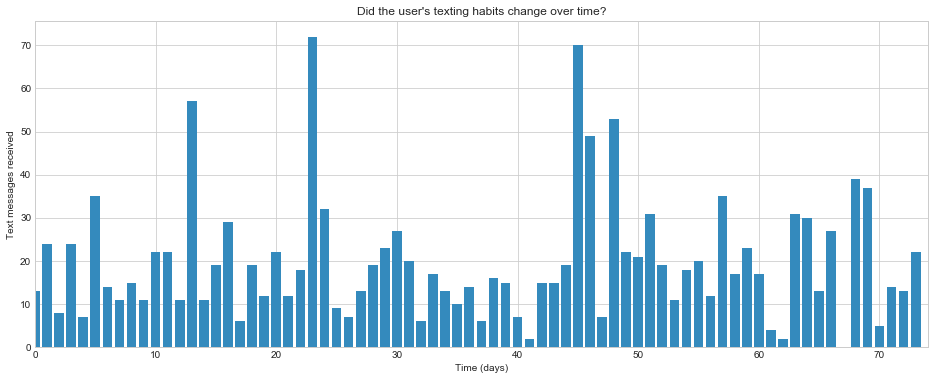

In [44]:
plt.figure(figsize=(16, 6))

plt.bar(np.arange(n_count_data), count_data, color="#348ABD")

plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)
plt.show()

# PyMC

In [27]:
alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

print("alpha: {}".format(alpha))
print("lambda_1: {}".format(lambda_1))
print("lambda_2: {}".format(lambda_2))
print("tau: {}".format(tau.value))

alpha: 0.05065023956194388
lambda_1: lambda_1
lambda_2: lambda_2
tau: 72


In [28]:
tau.get_stoch_value()

array([72])

In [29]:
print("Random output: ", tau.random(), tau.random(), tau.random())

Random output:  2 54 33


In [30]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [31]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [32]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 8.3 sec

In [33]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

In [34]:
len(lambda_1_samples), len(lambda_2_samples), len(tau_samples)

(30000, 30000, 30000)

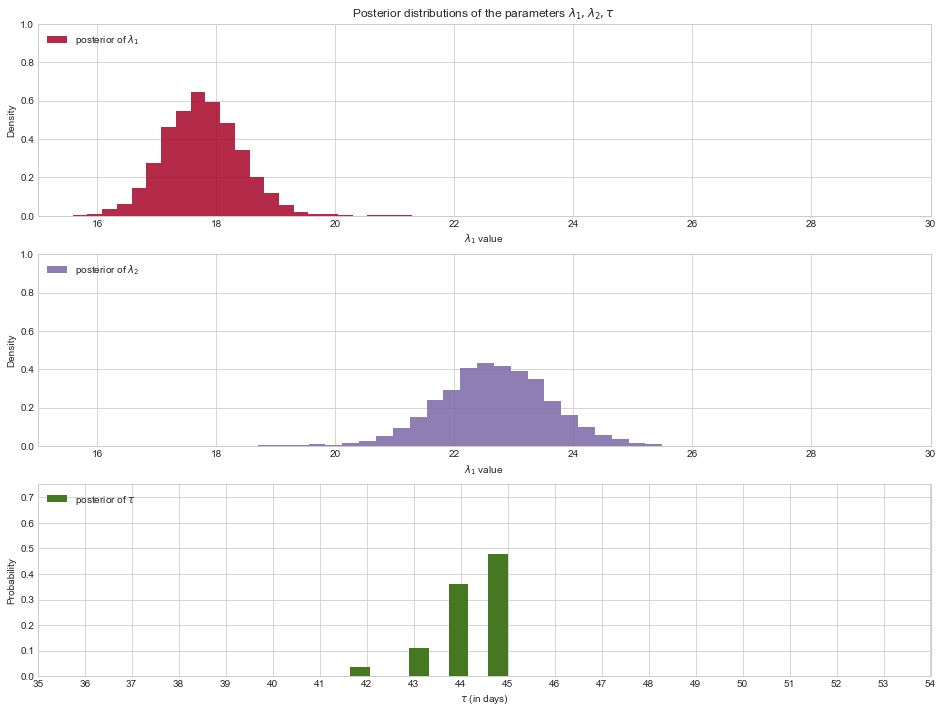

In [40]:
plt.figure(figsize=(16, 12))

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#A60628", normed=True, label="posterior of $\lambda_1$")
plt.legend(loc="upper left")
plt.title(r"Posterior distributions of the parameters $\lambda_1, \lambda_2, \tau$")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#7A68A6", normed=True, label="posterior of $\lambda_2$")
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1, label=r"posterior of $\tau$", color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, 0.75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability")

plt.show()